In [1]:
import os
import re
import math
import glob
from importlib import reload

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import osu.rulesets.beatmap as bm
import osu.rulesets.replay as rp
import osu.rulesets.hitobjects as hitobjects
import osu.dataset as dataset

import osu.preview.preview as preview

Rust acceleration available!
pygame 2.6.1 (SDL 2.28.4, Python 3.13.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


E:\Projects\osu\.venv\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [3]:
obj_dataset = dataset.replay_mapping_from_cache(10000)

Loading objects from .data/: 100%|██████████| 10000/10000 [02:36<00:00, 63.96it/s]


In [4]:
obj_dataset

,replay,beatmap
0,<osu.rulesets.replay._convert_rust_replay.<loc...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
1,<osu.rulesets.replay._convert_rust_replay.<loc...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
2,<osu.rulesets.replay._convert_rust_replay.<loc...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
3,<osu.rulesets.replay._convert_rust_replay.<loc...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
4,<osu.rulesets.replay._convert_rust_replay.<loc...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
...,...,...
4345,<osu.rulesets.replay._convert_rust_replay.<loc...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
4346,<osu.rulesets.replay._convert_rust_replay.<loc...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
4347,<osu.rulesets.replay._convert_rust_replay.<loc...,<osu.rulesets.beatmap.Beatmap object at 0x0000...
4348,<osu.rulesets.replay._convert_rust_replay.<loc...,<osu.rulesets.beatmap.Beatmap object at 0x0000...


In [ ]:
input_data = dataset.input_data(obj_dataset, verbose=True)
output_data = dataset.target_data(obj_dataset, verbose=True)

Turning beatmaps into time series data:  13%|█▎        | 576/4350 [04:30<35:20,  1.78it/s]  

In [7]:
input = input_data
output = output_data

In [34]:
output[0:500]

x         y
chunk frame                    
0     0     -0.153300 -0.073323
      1     -0.153300 -0.073323
      2     -0.150146 -0.068937
      3     -0.143331 -0.060010
      4     -0.143229 -0.059820
...               ...       ...
      495   -0.283915  0.042796
      496   -0.370483  0.244555
      497   -0.370483  0.244555
      498   -0.384115  0.277552
      499   -0.404663  0.334544

[500 rows x 2 columns]

In [13]:
import torch

xs = np.reshape(input.values, (-1, dataset.BATCH_LENGTH, len(dataset.INPUT_FEATURES)))

# try:
#     target_data = pd.read_pickle('.data/target_data.dat')
# except:
#     target_data = dataset.target_data(dataset, verbose=True)
#     target_data.to_pickle('.data/target_data.dat')

ys = np.reshape(output.values, (-1, dataset.BATCH_LENGTH, len(dataset.OUTPUT_FEATURES)))

xs.shape

50469

In [14]:
ys = ys[0:xs.shape[0]]

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from random import randint 
from torch.utils.data import DataLoader, TensorDataset

EPOCHS = 100
BATCH_SIZE = 64

x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size=0.2, random_state=randint(0, 100))

train_dataset = TensorDataset(torch.FloatTensor(x_train), torch.FloatTensor(y_train))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [16]:

# punish for not smooth movements
# class VelocityAwareLoss(nn.Module):
#     def __init__(self, position_weight=1.0, velocity_weight=0.3):
#         super().__init__()
#         self.pos_weight = position_weight
#         self.vel_weight = velocity_weight
#         
#     def forward(self, pred, target):
#         # Position loss
#         pos_loss = F.mse_loss(pred, target)
#         
#         # Velocity loss (differences between consecutive timesteps)
#         pred_vel = pred[:, 1:] - pred[:, :-1]
#         target_vel = target[:, 1:] - target[:, :-1]
#         vel_loss = F.mse_loss(pred_vel, target_vel)
#         
#         return self.pos_weight * pos_loss + self.vel_weight * vel_loss

class OsuModel(nn.Module):
    def __init__(self, input_size, output_size, noise_std=0.2):
        super(OsuModel, self).__init__()
        
        self.lstm = nn.LSTM(input_size, 64, batch_first=True)
        self.dense1 = nn.Linear(64, 64)
        self.noise_std = noise_std
        self.dense2 = nn.Linear(64, 16)
        self.position = nn.Linear(16, output_size)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        
        pos = self.dense1(lstm_out)
        
        # gaussian noise (only applied during training)
        if self.training:
            noise = torch.randn_like(pos) * self.noise_std
            pos = pos + noise
        
        pos = self.dense2(pos)
        pos = self.position(pos)
        
        return pos

input_size = xs.shape[2]  # feature dimension
output_size = ys.shape[2]  # output dimension

model = OsuModel(input_size, output_size)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
criterion = torch.nn.SmoothL1Loss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.load_state_dict(torch.load(".trained/most_recent.pt"))
print(model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

OsuModel(
  (lstm): LSTM(5, 64, batch_first=True)
  (dense1): Linear(in_features=64, out_features=64, bias=True)
  (dense2): Linear(in_features=64, out_features=16, bias=True)
  (position): Linear(in_features=16, out_features=2, bias=True)
)
Total parameters: 23410


In [17]:
epoch_losses = []

In [23]:
import tqdm

for epoch in range(EPOCHS):
    epoch_loss = 0
    for batch_x, batch_y in tqdm.tqdm(train_loader):
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        # print(batch_x.shape)
        # print(batch_y.shape)
        optimizer.zero_grad()
        outputs = model(batch_x)
        
        loss = criterion(outputs, batch_y)
        loss.backward()
        
        optimizer.step()

        epoch_loss += loss.item()
    epoch_loss = epoch_loss/len(train_loader)
    print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}')
    epoch_losses.append(epoch_loss)
    

100%|██████████| 631/631 [00:16<00:00, 37.65it/s]


Epoch 1/100, Loss: 0.0250


100%|██████████| 631/631 [00:12<00:00, 50.44it/s]


Epoch 2/100, Loss: 0.0250


100%|██████████| 631/631 [00:17<00:00, 36.93it/s]


Epoch 3/100, Loss: 0.0250


100%|██████████| 631/631 [00:17<00:00, 36.21it/s]


Epoch 4/100, Loss: 0.0250


100%|██████████| 631/631 [00:17<00:00, 35.72it/s]


Epoch 5/100, Loss: 0.0250


100%|██████████| 631/631 [00:17<00:00, 35.75it/s]


Epoch 6/100, Loss: 0.0250


100%|██████████| 631/631 [00:12<00:00, 50.14it/s]


Epoch 7/100, Loss: 0.0250


100%|██████████| 631/631 [00:13<00:00, 45.24it/s]


Epoch 8/100, Loss: 0.0250


100%|██████████| 631/631 [00:13<00:00, 46.53it/s]


Epoch 9/100, Loss: 0.0250


100%|██████████| 631/631 [00:17<00:00, 35.19it/s]


Epoch 10/100, Loss: 0.0250


100%|██████████| 631/631 [00:17<00:00, 35.78it/s]


Epoch 11/100, Loss: 0.0250


100%|██████████| 631/631 [00:18<00:00, 34.72it/s]


Epoch 12/100, Loss: 0.0250


100%|██████████| 631/631 [00:18<00:00, 35.01it/s]


Epoch 13/100, Loss: 0.0250


100%|██████████| 631/631 [00:18<00:00, 34.94it/s]


Epoch 14/100, Loss: 0.0250


100%|██████████| 631/631 [00:18<00:00, 35.05it/s]


Epoch 15/100, Loss: 0.0250


100%|██████████| 631/631 [00:18<00:00, 34.61it/s]


Epoch 16/100, Loss: 0.0250


100%|██████████| 631/631 [00:19<00:00, 32.90it/s]


Epoch 17/100, Loss: 0.0250


100%|██████████| 631/631 [00:18<00:00, 34.09it/s]


Epoch 18/100, Loss: 0.0250


100%|██████████| 631/631 [00:17<00:00, 35.48it/s]


Epoch 19/100, Loss: 0.0250


100%|██████████| 631/631 [00:17<00:00, 35.52it/s]


Epoch 20/100, Loss: 0.0250


100%|██████████| 631/631 [00:18<00:00, 34.87it/s]


Epoch 21/100, Loss: 0.0250


100%|██████████| 631/631 [00:18<00:00, 33.85it/s]


Epoch 22/100, Loss: 0.0250


100%|██████████| 631/631 [00:18<00:00, 33.81it/s]


Epoch 23/100, Loss: 0.0250


100%|██████████| 631/631 [00:18<00:00, 34.14it/s]


Epoch 24/100, Loss: 0.0250


100%|██████████| 631/631 [00:18<00:00, 34.65it/s]


Epoch 25/100, Loss: 0.0250


100%|██████████| 631/631 [00:18<00:00, 33.39it/s]


Epoch 26/100, Loss: 0.0250


100%|██████████| 631/631 [00:19<00:00, 32.50it/s]


Epoch 27/100, Loss: 0.0250


100%|██████████| 631/631 [00:18<00:00, 33.61it/s]


Epoch 28/100, Loss: 0.0250


100%|██████████| 631/631 [00:18<00:00, 33.41it/s]


Epoch 29/100, Loss: 0.0250


100%|██████████| 631/631 [00:19<00:00, 33.03it/s]


Epoch 30/100, Loss: 0.0250


100%|██████████| 631/631 [00:18<00:00, 33.33it/s]


Epoch 31/100, Loss: 0.0250


100%|██████████| 631/631 [00:18<00:00, 34.31it/s]


Epoch 32/100, Loss: 0.0250


100%|██████████| 631/631 [00:18<00:00, 33.84it/s]


Epoch 33/100, Loss: 0.0250


100%|██████████| 631/631 [00:18<00:00, 34.04it/s]


Epoch 34/100, Loss: 0.0250


100%|██████████| 631/631 [00:18<00:00, 34.01it/s]


Epoch 35/100, Loss: 0.0250


100%|██████████| 631/631 [00:15<00:00, 39.61it/s]


Epoch 36/100, Loss: 0.0250


100%|██████████| 631/631 [00:13<00:00, 45.94it/s]


Epoch 37/100, Loss: 0.0250


100%|██████████| 631/631 [00:13<00:00, 45.74it/s]


Epoch 38/100, Loss: 0.0250


100%|██████████| 631/631 [00:13<00:00, 45.14it/s]


Epoch 39/100, Loss: 0.0250


100%|██████████| 631/631 [00:15<00:00, 39.49it/s]


Epoch 40/100, Loss: 0.0250


100%|██████████| 631/631 [00:16<00:00, 38.01it/s]


Epoch 41/100, Loss: 0.0250


100%|██████████| 631/631 [00:15<00:00, 39.65it/s]


Epoch 42/100, Loss: 0.0250


100%|██████████| 631/631 [00:16<00:00, 39.42it/s]


Epoch 43/100, Loss: 0.0250


100%|██████████| 631/631 [00:15<00:00, 39.57it/s]


Epoch 44/100, Loss: 0.0250


100%|██████████| 631/631 [00:15<00:00, 41.40it/s]


Epoch 45/100, Loss: 0.0250


100%|██████████| 631/631 [00:14<00:00, 44.12it/s]


Epoch 46/100, Loss: 0.0250


100%|██████████| 631/631 [00:14<00:00, 43.95it/s]


Epoch 47/100, Loss: 0.0250


100%|██████████| 631/631 [00:14<00:00, 44.82it/s]


Epoch 48/100, Loss: 0.0250


100%|██████████| 631/631 [00:16<00:00, 38.84it/s]


Epoch 49/100, Loss: 0.0250


100%|██████████| 631/631 [00:18<00:00, 34.97it/s]


Epoch 50/100, Loss: 0.0250


100%|██████████| 631/631 [00:18<00:00, 34.82it/s]


Epoch 51/100, Loss: 0.0250


100%|██████████| 631/631 [00:18<00:00, 34.10it/s]


Epoch 52/100, Loss: 0.0250


100%|██████████| 631/631 [00:18<00:00, 34.04it/s]


Epoch 53/100, Loss: 0.0250


100%|██████████| 631/631 [00:17<00:00, 35.95it/s]


Epoch 54/100, Loss: 0.0250


100%|██████████| 631/631 [00:18<00:00, 34.91it/s]


Epoch 55/100, Loss: 0.0250


100%|██████████| 631/631 [00:18<00:00, 34.95it/s]


Epoch 56/100, Loss: 0.0250


100%|██████████| 631/631 [00:17<00:00, 36.11it/s]


Epoch 57/100, Loss: 0.0250


100%|██████████| 631/631 [00:18<00:00, 34.48it/s]


Epoch 58/100, Loss: 0.0250


100%|██████████| 631/631 [00:17<00:00, 36.85it/s]


Epoch 59/100, Loss: 0.0250


100%|██████████| 631/631 [00:17<00:00, 35.13it/s]


Epoch 60/100, Loss: 0.0250


100%|██████████| 631/631 [00:18<00:00, 34.99it/s]


Epoch 61/100, Loss: 0.0250


100%|██████████| 631/631 [00:18<00:00, 34.15it/s]


Epoch 62/100, Loss: 0.0250


100%|██████████| 631/631 [00:12<00:00, 50.46it/s]


Epoch 63/100, Loss: 0.0250


100%|██████████| 631/631 [00:13<00:00, 47.12it/s]


Epoch 64/100, Loss: 0.0250


100%|██████████| 631/631 [00:15<00:00, 41.53it/s]


Epoch 65/100, Loss: 0.0250


100%|██████████| 631/631 [00:17<00:00, 36.04it/s]


Epoch 66/100, Loss: 0.0250


100%|██████████| 631/631 [00:17<00:00, 35.63it/s]


Epoch 67/100, Loss: 0.0250


100%|██████████| 631/631 [00:17<00:00, 35.50it/s]


Epoch 68/100, Loss: 0.0250


100%|██████████| 631/631 [00:17<00:00, 35.66it/s]


Epoch 69/100, Loss: 0.0250


100%|██████████| 631/631 [00:15<00:00, 41.52it/s]


Epoch 70/100, Loss: 0.0250


100%|██████████| 631/631 [00:12<00:00, 50.05it/s]


Epoch 71/100, Loss: 0.0250


100%|██████████| 631/631 [00:13<00:00, 47.04it/s]


Epoch 72/100, Loss: 0.0250


100%|██████████| 631/631 [00:13<00:00, 47.06it/s]


Epoch 73/100, Loss: 0.0250


100%|██████████| 631/631 [00:13<00:00, 47.23it/s]


Epoch 74/100, Loss: 0.0250


100%|██████████| 631/631 [00:13<00:00, 47.00it/s]


Epoch 75/100, Loss: 0.0250


100%|██████████| 631/631 [00:13<00:00, 47.79it/s]


Epoch 76/100, Loss: 0.0250


100%|██████████| 631/631 [00:13<00:00, 47.75it/s]


Epoch 77/100, Loss: 0.0250


100%|██████████| 631/631 [00:13<00:00, 46.68it/s]


Epoch 78/100, Loss: 0.0250


100%|██████████| 631/631 [00:13<00:00, 46.89it/s]


Epoch 79/100, Loss: 0.0250


100%|██████████| 631/631 [00:13<00:00, 46.92it/s]


Epoch 80/100, Loss: 0.0250


100%|██████████| 631/631 [00:13<00:00, 47.25it/s]


Epoch 81/100, Loss: 0.0250


100%|██████████| 631/631 [00:13<00:00, 46.43it/s]


Epoch 82/100, Loss: 0.0250


100%|██████████| 631/631 [00:13<00:00, 46.21it/s]


Epoch 83/100, Loss: 0.0250


100%|██████████| 631/631 [00:13<00:00, 46.78it/s]


Epoch 84/100, Loss: 0.0250


100%|██████████| 631/631 [00:13<00:00, 48.21it/s]


Epoch 85/100, Loss: 0.0250


100%|██████████| 631/631 [00:13<00:00, 47.59it/s]


Epoch 86/100, Loss: 0.0250


100%|██████████| 631/631 [00:13<00:00, 46.68it/s]


Epoch 87/100, Loss: 0.0250


100%|██████████| 631/631 [00:13<00:00, 47.26it/s]


Epoch 88/100, Loss: 0.0250


100%|██████████| 631/631 [00:13<00:00, 47.47it/s]


Epoch 89/100, Loss: 0.0250


100%|██████████| 631/631 [00:13<00:00, 47.00it/s]


Epoch 90/100, Loss: 0.0250


100%|██████████| 631/631 [00:13<00:00, 47.15it/s]


Epoch 91/100, Loss: 0.0250


100%|██████████| 631/631 [00:13<00:00, 47.60it/s]


Epoch 92/100, Loss: 0.0250


100%|██████████| 631/631 [00:13<00:00, 48.22it/s]


Epoch 93/100, Loss: 0.0250


100%|██████████| 631/631 [00:13<00:00, 47.58it/s]


Epoch 94/100, Loss: 0.0250


100%|██████████| 631/631 [00:13<00:00, 46.81it/s]


Epoch 95/100, Loss: 0.0250


100%|██████████| 631/631 [00:13<00:00, 46.15it/s]


Epoch 96/100, Loss: 0.0250


100%|██████████| 631/631 [00:13<00:00, 46.37it/s]


Epoch 97/100, Loss: 0.0250


100%|██████████| 631/631 [00:13<00:00, 46.64it/s]


Epoch 98/100, Loss: 0.0250


100%|██████████| 631/631 [00:13<00:00, 46.70it/s]


Epoch 99/100, Loss: 0.0250


100%|██████████| 631/631 [00:13<00:00, 46.76it/s]

Epoch 100/100, Loss: 0.0250


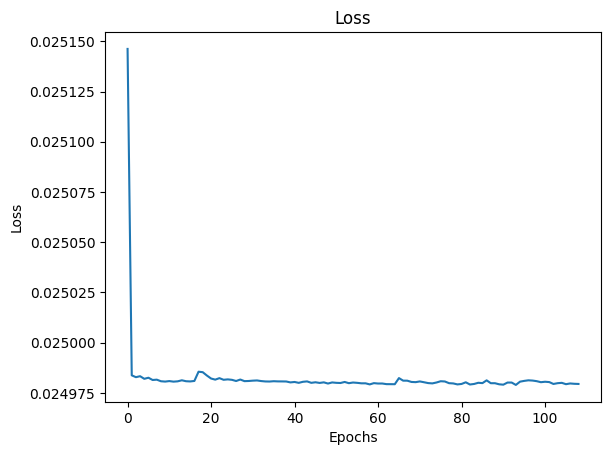

In [24]:
import matplotlib.pyplot as plt

plt.plot(epoch_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss")
plt.show()

if not os.path.exists('.trained'):
    os.makedirs('.trained')

import datetime
now = datetime.datetime.now()
torch.save(model.state_dict(), f'.trained/{now.strftime("%Y-%m-%d_%H-%M-%S")}.pt')
torch.save(model.state_dict(), f'.trained/most_recent.pt')

In [26]:
import osu.rulesets.beatmap as bm
import osu.rulesets.replay as rp
import osu.dataset as dataset

test_name = 'rubiks'

test_map = f'assets/{test_name}_map.osu'
test_song = f'assets/{test_name}_song.mp3'

test_map = bm.load(test_map)

data = dataset.input_data(test_map)
data = np.reshape(data.values, (-1, dataset.BATCH_LENGTH, len(dataset.INPUT_FEATURES)))
data = torch.FloatTensor(data).to(device)

Turning beatmaps into time series data: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


In [27]:
with torch.no_grad():
    replay_data = model(data).to('cpu').numpy()
    
replay_data = np.concatenate(replay_data)
if not os.path.exists('.generated'):
    os.makedirs('.generated')
    
np.save('.generated\\' + test_name + '.npy', replay_data)

In [28]:
import osu.preview.preview as preview

preview.preview_replay(replay_data, test_map, test_song)